### Test Lindbladian invariance properties

In [1]:
using QuantumOptics
using LinearAlgebra

include("LiPoSID.jl")

Main.LiPoSID

In [2]:
function Lindblad_time_evolution(basis, ρ₀, time_span, H, J)
         
    ρ₀ = DenseOperator(basis, Hermitian(ρ₀)) 
    H = DenseOperator(basis, H) # reconstructed Hamiltonian of the system
    #H = DenseOperator(basis, convert(Matrix{ComplexF64}, H[:,:,1]) ) # !!!!!!
    J = [ DenseOperator(basis, Jᵢ) for Jᵢ in J ] # reconstracted Lindblad decipators
    
    time, ρ  = timeevolution.master(time_span, ρ₀, H, J)
    
    ρ = [ρₜ.data for ρₜ in ρ]

end

Lindblad_time_evolution (generic function with 1 method)

$
\frac{d\rho}{dt}=-\frac{i}{\hbar}[H, \rho]+\left[A \rho A^\dagger - \frac{1}{2}\left\{ A^\dagger A, \rho \right\} \right]
$

$
A = \begin{pmatrix} 0 & a \\ 0 & 0
   \end{pmatrix}$

$
     \frac{d\rho}{dt} = - \frac{i}{\hbar}[H, \rho]+\left[L \rho L^\dagger - \frac{1}{2}\left\{ L^\dagger L, \rho \right\} \right]
$

$
L = \sqrt{\gamma} \sigma = \begin{pmatrix} 0 & \sqrt{\gamma} \\ 0 & 0
   \end{pmatrix} = \begin{pmatrix} 0 & a \\ 0 & 0
   \end{pmatrix}$
   



In [3]:
Hᵃⁿᶻ = [ 25.           0
         0             1    ]

γ = 0.079477

Lᵃⁿᶻ = [ 0    √γ
         0     0. + 0im  ]

2×2 Matrix{ComplexF64}:
 0.0+0.0im  0.281917+0.0im
 0.0+0.0im       0.0+0.0im

### Generate ansatz dynamics

In [4]:
# Initial states

Ψᵍ₀ = [1.
       0im]
Ψᵉ₀ = [0im
       1.]
ρᵍ₀ = Ψᵍ₀ * Ψᵍ₀' 
ρᵉ₀ = Ψᵉ₀ * Ψᵉ₀' 
ρˣ₀ = [1.  1 + 0im
       1   1]/2 
ρʸ₀ = [1. -1im
       1im  1]/2

# Time span 

t₀ = 0.06
Δt = 0.020000000000000004
n = 1256
t = range(t₀, n*Δt, n)
t = convert(Vector{Float64}, t)

@assert maximum(diff(t)) ≈ minimum(diff(t)) ≈ t[2]-t[1]

basis = NLevelBasis(2)

NLevel(N=2)

In [5]:
ρᵍₐₙ = Lindblad_time_evolution(basis, ρᵍ₀, t, Hᵃⁿᶻ, [Lᵃⁿᶻ])
ρᵉₐₙ = Lindblad_time_evolution(basis, ρᵉ₀, t, Hᵃⁿᶻ, [Lᵃⁿᶻ])
ρˣₐₙ = Lindblad_time_evolution(basis, ρˣ₀, t, Hᵃⁿᶻ, [Lᵃⁿᶻ])
ρʸₐₙ = Lindblad_time_evolution(basis, ρʸ₀, t, Hᵃⁿᶻ, [Lᵃⁿᶻ])


using DynamicPolynomials

@polyvar e[1:2]
@polyvar d[1:2]

    Hˢʸᵐᵇ = [ e[1]               d[1] + im*d[2]
              d[1] - im*d[2]     0.             ]

@polyvar a[1:4]
@polyvar b[1:4]

    Aˢʸᵐᵇ = [ a[1] + im*b[1]           a[2] + im*b[2]
              a[3] + im*b[3]           a[4] + im*b[4]   ]


#    POP fails for traceless setup 
#    Aˢʸᵐᵇ = [ a[1] + im*b[1]           a[2] + im*b[2]
#             a[3] + im*b[3]          -a[1] - im*b[1]   ]

objₐₙ = 0

for ρ in [ρᵍₐₙ, ρᵉₐₙ, ρˣₐₙ, ρʸₐₙ]

    # Convert cut ρ series:
    ρ = convert(Vector{Matrix{ComplexF64}}, ρ)

    objₐₙ += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇ, [Aˢʸᵐᵇ])

end # of files (initial states) loop 

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to 

In [6]:
solₐₙᵒˡᵈ, best_methodₐₙᵒˡᵈ = LiPoSID.sos_min(objₐₙ) 
Hˢⁱᵈ = subs(Hˢʸᵐᵇ, solₐₙᵒˡᵈ)
Lˢⁱᵈ = subs(Aˢʸᵐᵇ, solₐₙᵒˡᵈ)

************************TSSOS************************
TSSOS is launching...
optimum = 3.2500102297564724e-7

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Found a local optimal solution giving an upper bound: 0.010593796849150294 and a relative optimality gap: 0.010593471848127319.
optimum = 4.631885936585784e-7
Found a local optimal solution giving an upper bound: 0.010593796849207138 and a relative optimality gap: 0.010593333660613479.
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = -4.5824573691702466e-7
Global optimality certified!
optimum = -9.181961801744589e-9
Global optimality cer

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (-1.0847-3.07829im)        (-0.24327-0.14242im)
 (9.59996e-8-6.47418e-7im)  (-1.0847-3.07829im)

In [7]:
best_methodₐₙᵒˡᵈ

"scaled_tssos"

In [8]:
Hˢⁱᵈ

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (23.9928+0.0im)         (-0.297185-0.351141im)
 (-0.297185+0.351141im)  0.0+0.0im

In [9]:
Lˢⁱᵈ

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (-1.0847-3.07829im)        (-0.24327-0.14242im)
 (9.59996e-8-6.47418e-7im)  (-1.0847-3.07829im)

In [10]:
solₐₙⁿᵉʷ, best_methodₐₙⁿᵉʷ = LiPoSID.sos_min_newton(objₐₙ) 

************************TSSOS************************
TSSOS is launching...
optimum = 1.476921539926401e-7
The local solver failed!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = -8.273196778967306e-9
Global optimality certified!
No higher TSSOS hierarchy!


(PolyVar{true}[e₁, d₁, d₂, a₁, a₂, a₃, a₄, b₁, b₂, b₃, b₄] => [23.99277344139119, -0.489170166603519, -0.04000401286439872, 2.285013885890328, -0.19692815988492263, 5.149723224078382e-7, 2.2850142268752758, -2.6276261586389333, -0.2017002897989913, -6.851471519267653e-8, -2.6276260542353636], "scaled_tssos")

In [11]:
Hˢⁱᵈⁿᵉʷ = subs(Hˢʸᵐᵇ, solₐₙⁿᵉʷ)

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (23.9928+0.0im)        (-0.48917-0.040004im)
 (-0.48917+0.040004im)  0.0+0.0im

In [12]:
Lˢⁱᵈⁿᵉʷ = subs(Aˢʸᵐᵇ, solₐₙⁿᵉʷ)

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (2.28501-2.62763im)        (-0.196928-0.2017im)
 (5.14972e-7-6.85147e-8im)  (2.28501-2.62763im)

$L' = L + a I$

$ a = -\operatorname{tr}(L)/2$

$ H' = H + \frac{1}{2i} (a^*L - a L^\dagger)$

### Fix SID

In [13]:
function fix_hamiltonian_and_dissipator(H, L)
    a = - tr(L)/2
    return convert.(ComplexF64,  H + (a' * L - a * L')/2im), convert.(ComplexF64, L + I * a)
end

fix_hamiltonian_and_dissipator (generic function with 1 method)

In [14]:
Hˢⁱᵈᶠⁱˣ, Lˢⁱᵈᶠⁱˣ = fix_hamiltonian_and_dissipator(Hˢⁱᵈ, Lˢⁱᵈ)

(ComplexF64[23.992774141005963 + 0.0im 2.0612260842600705e-8 - 1.6085713594460316e-8im; 2.0612260842600705e-8 + 1.6085713594460316e-8im -4.367337766986168e-7 + 0.0im], ComplexF64[-1.3675643684152305e-7 + 1.4527465008740137e-8im 0.8414255504765911 + 2.9358690778271033im; 1.0846952814363922 + 3.078288858492506im 1.3675643706356766e-7 - 1.4527465008740137e-8im])

In [15]:
Lˢⁱᵈᶠⁱˣ

2×2 Matrix{ComplexF64}:
 -1.36756e-7+1.45275e-8im    0.841426+2.93587im
      1.0847+3.07829im     1.36756e-7-1.45275e-8im

In [16]:
Hᶠⁱˣⁿᵉʷ, Lᶠⁱˣⁿᵉʷ = fix_hamiltonian_and_dissipator(Hˢⁱᵈⁿᵉʷ, Lˢⁱᵈⁿᵉʷ)
Hᶠⁱˣⁿᵉʷ

2×2 Matrix{ComplexF64}:
    23.9928+0.0im          2.07844e-8-2.43809e-8im
 2.07844e-8+2.43809e-8im  -5.67272e-7+0.0im

In [17]:
Lᶠⁱˣⁿᵉʷ

2×2 Matrix{ComplexF64}:
 -1.70492e-7-5.22018e-8im    -2.48194+2.42593im
    -2.28501+2.62763im     1.70492e-7+5.22018e-8im

### Consider dynamics

In [18]:
using QuantumOptics

basis = NLevelBasis(2)

NLevel(N=2)

In [19]:
# Initial states

Ψᵍ₀ = [1.
       0im]
Ψᵉ₀ = [0im
       1.]
ρᵍ₀ = Ψᵍ₀ * Ψᵍ₀' 
ρᵉ₀ = Ψᵉ₀ * Ψᵉ₀' 
ρˣ₀ = [1.  1 + 0im
       1   1]/2 
ρʸ₀ = [1. -1im
       1im  1]/2

# Time span 

t₀ = 0.06
Δt = 0.020000000000000004
n = 1256
t = range(t₀, n*Δt, n)
t = convert(Vector{Float64}, t)

@assert maximum(diff(t)) ≈ minimum(diff(t)) ≈ t[2]-t[1]

In [20]:
ρˢⁱᵈ = Lindblad_time_evolution(basis, ρʸ₀, t, Hˢⁱᵈ, [Lˢⁱᵈ])
ρˢⁱᵈᶠⁱˣ = Lindblad_time_evolution(basis, ρʸ₀, t, Hˢⁱᵈᶠⁱˣ, [Lˢⁱᵈᶠⁱˣ])

maximum(norm.(ρˢⁱᵈ - ρˢⁱᵈᶠⁱˣ))

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360


0.7074696827760789

In [21]:
fidelity.( [DenseOperator(basis, ρ) for ρ in ρˢⁱᵈ], [DenseOperator(basis, ρ) for ρ in ρˢⁱᵈᶠⁱˣ])

1256-element Vector{ComplexF64}:
 0.9999999999999997 + 0.0im
 0.9290769873310301 - 2.142432286523307e-15im
 0.9028955254876944 - 1.4107246386288123e-16im
  0.903442065671783 + 2.948626743036664e-16im
 0.9021149181885877 + 2.0754014243668163e-16im
 0.8838367494677263 + 1.4041496694769646e-16im
 0.8518562127017499 - 1.5288215820908943e-16im
 0.8198698427168982 + 4.411073454076671e-16im
  0.799960557453911 - 3.0581695895929344e-16im
 0.7941097603570061 + 2.8194732569248337e-16im
 0.7952680240140138 + 9.509393358389369e-17im
 0.7950769586331005 + 6.718451997103934e-16im
 0.7899062060199822 + 4.0020777415046953e-16im
                    ⋮
 0.8025070967234627 - 1.061445179804734e-16im
 0.8024310168300306 - 1.0470866637250695e-16im
 0.8023549581354522 - 7.087252873727514e-17im
 0.8022789225604214 - 5.0013480524272286e-17im
 0.8022029111215778 - 1.4912884682284217e-16im
 0.8021269231319659 - 1.144080188904937e-16im
 0.8020509587258864 - 1.313095317637618e-16im
 0.8019750184459142 - 1.069446223

In [22]:
ρ₀ = ρˣ₀

ρᵃⁿᶻ = Lindblad_time_evolution(basis, ρ₀, t, Hᵃⁿᶻ, [Lᵃⁿᶻ])

ρˢⁱᵈ = Lindblad_time_evolution(basis, ρ₀, t, Hˢⁱᵈ, [Lˢⁱᵈ])
ρˢⁱᵈᶠⁱˣ = Lindblad_time_evolution(basis, ρ₀, t, Hˢⁱᵈᶠⁱˣ, [Lˢⁱᵈᶠⁱˣ])

ρˢⁱᵈⁿᵉʷ = Lindblad_time_evolution(basis, ρ₀, t, Hˢⁱᵈⁿᵉʷ, [Lˢⁱᵈⁿᵉʷ])
ρᶠⁱˣⁿᵉʷ = Lindblad_time_evolution(basis, ρ₀, t, Hᶠⁱˣⁿᵉʷ, [Lᶠⁱˣⁿᵉʷ]);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to 

In [23]:
using Plots

In [24]:
fᵃⁿᶻ⁻ˢⁱᵈ = LiPoSID.fidelity_series(basis, ρᵃⁿᶻ, ρˢⁱᵈ)
fⁿᵉʷ⁻ˢⁱᵈ⁻ᵃⁿᶻ = LiPoSID.fidelity_series(basis, ρˢⁱᵈⁿᵉʷ, ρᵃⁿᶻ)

fˢⁱᵈ⁻ᶠⁱˣ = LiPoSID.fidelity_series(basis, ρˢⁱᵈ, ρˢⁱᵈᶠⁱˣ)
fˢⁱᵈ⁻ᶠⁱˣ⁻ᵃⁿᶻ = LiPoSID.fidelity_series(basis, ρˢⁱᵈ, ρᵃⁿᶻ)

fⁿᵉʷ⁻ˢⁱᵈ⁻ᶠⁱˣ = LiPoSID.fidelity_series(basis, ρˢⁱᵈⁿᵉʷ, ρᶠⁱˣⁿᵉʷ)
fⁿᵉʷ⁻ˢⁱᵈ⁻ᶠⁱˣ⁻ᵃⁿᶻ = LiPoSID.fidelity_series(basis, ρˢⁱᵈⁿᵉʷ, ρᵃⁿᶻ);

In [25]:
minimum(fᵃⁿᶻ⁻ˢⁱᵈ)

0.9994421528984818

In [26]:
minimum(fˢⁱᵈ⁻ᶠⁱˣ)

0.7662295856837615

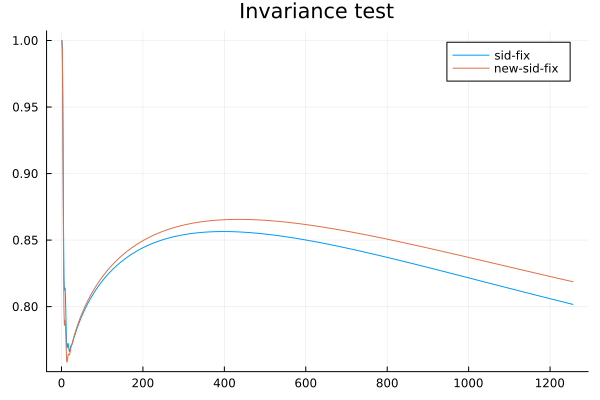

In [27]:
plot(fˢⁱᵈ⁻ᶠⁱˣ, label = "sid-fix")
plot!(fⁿᵉʷ⁻ˢⁱᵈ⁻ᶠⁱˣ, label ="new-sid-fix")
title!("Invariance test")

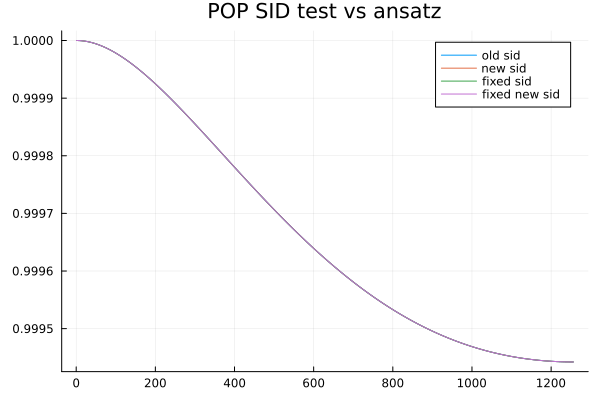

In [28]:
plot(fᵃⁿᶻ⁻ˢⁱᵈ, label = "old sid")
plot!(fⁿᵉʷ⁻ˢⁱᵈ⁻ᵃⁿᶻ, label ="new sid")
plot!(fˢⁱᵈ⁻ᶠⁱˣ⁻ᵃⁿᶻ, label ="fixed sid")
plot!(fⁿᵉʷ⁻ˢⁱᵈ⁻ᶠⁱˣ⁻ᵃⁿᶻ, label ="fixed new sid")
title!("POP SID test vs ansatz")

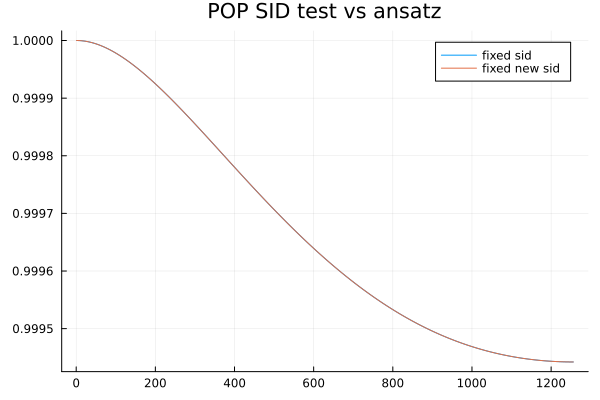

In [29]:
plot(fˢⁱᵈ⁻ᶠⁱˣ⁻ᵃⁿᶻ, label ="fixed sid")
plot!(fⁿᵉʷ⁻ˢⁱᵈ⁻ᶠⁱˣ⁻ᵃⁿᶻ, label ="fixed new sid")
title!("POP SID test vs ansatz")

In [30]:
minimum(fⁿᵉʷ⁻ˢⁱᵈ⁻ᶠⁱˣ⁻ᵃⁿᶻ)

0.9994421527555741

In [31]:
bᵃⁿᶻ = LiPoSID.bloch(ρᵃⁿᶻ)
bᶠⁱˣ = LiPoSID.bloch(ρˢⁱᵈᶠⁱˣ)
bˢⁱᵈ = LiPoSID.bloch(ρˢⁱᵈ)
bˢⁱᵈⁿᵉʷ = LiPoSID.bloch(ρˢⁱᵈⁿᵉʷ)
bᶠⁱˣⁿᵉʷ = LiPoSID.bloch(ρᶠⁱˣⁿᵉʷ)

3×1256 Matrix{Float64}:
 1.0   0.902869     0.681648     0.423361    …   9.25478e-8   9.25478e-8
 0.0   0.350802     0.504636     0.509432       -3.75941e-9  -3.75941e-9
 0.0  -0.00127589  -0.00206331  -0.00254926     -0.00333213  -0.00333232

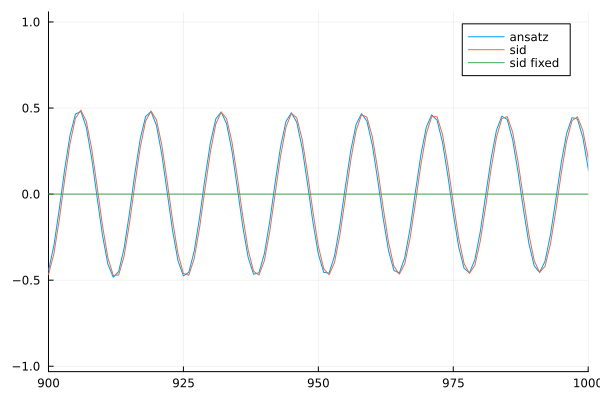

In [32]:
bv = 1

plot(bᵃⁿᶻ[bv,:], label="ansatz") 
plot!(bˢⁱᵈ[bv,:], label="sid")
plot!(bᶠⁱˣ[bv,:], label="sid fixed") 

xlims!(900, 1000)
#ylims!(0,0.5)

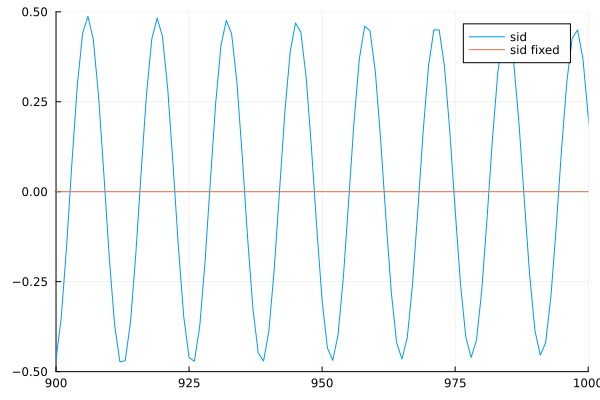

In [33]:
bv = 1

plot(bˢⁱᵈ[bv,:], label="sid")
plot!(bᶠⁱˣ[bv,:], label="sid fixed") 

xlims!(900, 1000)
ylims!(-0.5,0.5)